In [1]:
import import_ipynb
import warnings
warnings.filterwarnings('ignore')
from colorit import *
init_colorit()

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
 


# Part 1: Data Inspection

In [2]:
coint_prices = pd.read_csv('data.csv',index_col = 'Date')
coint_prices.head(10)

BABA          FB
Date                             
2016-01-04  76.690002  102.220001
2016-01-05  78.629997  102.730003
2016-01-06  77.330002  102.970001
2016-01-07  72.720001   97.919998
2016-01-08  70.800003   97.330002
2016-01-11  69.919998   97.510002
2016-01-12  72.680000   99.370003
2016-01-13  70.290001   95.440002
2016-01-14  72.250000   98.370003
2016-01-15  69.589996   94.970001

Text(0.5, 1.0, 'Facebook vs Alibaba')

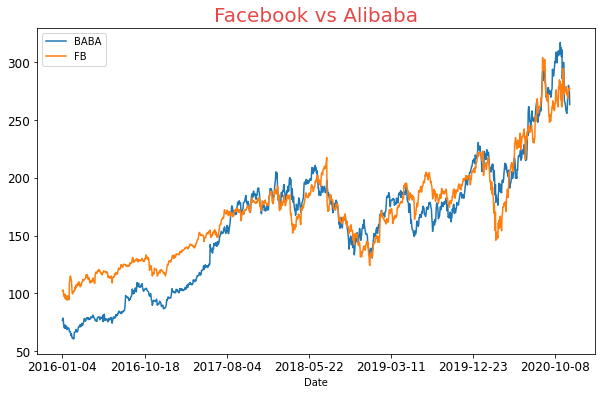

In [3]:
coint_prices.plot(figsize = (10,6), 
                  fontsize = 12,)
plt.title('Facebook vs Alibaba',
          fontsize = 20,
         color = '#E64848')

Text(0.5, 1.0, 'Alibaba - Facebook price difference')

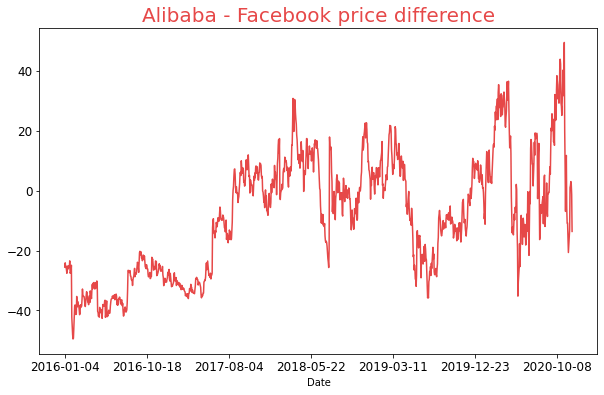

In [4]:
prices_diff = coint_prices.BABA - coint_prices.FB
prices_diff.plot(figsize = (10,6), 
                  fontsize = 12,
                color = '#E64848')
plt.title('Alibaba - Facebook price difference',
          fontsize = 20,
         color = '#E64848')

Text(0.5, 1.0, 'Facebook vs Alibaba')

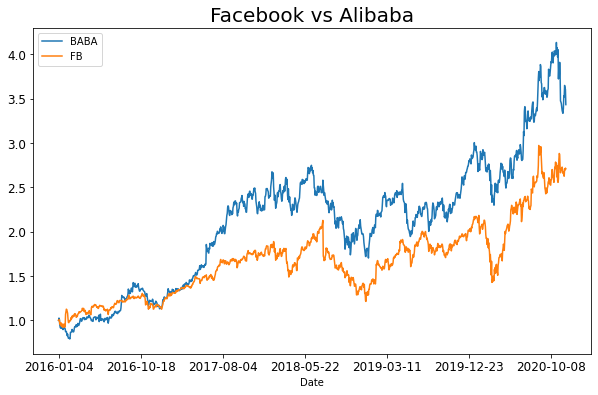

In [5]:
coint_prices = coint_prices/coint_prices.iloc[0]
coint_prices.plot(figsize = (10,6), 
                  fontsize = 12,)
plt.title('Facebook vs Alibaba',fontsize = 20)

In [6]:
# return

In [7]:
returns = np.log(coint_prices).diff().dropna()
returns.head()

BABA        FB
Date                          
2016-01-05  0.024982  0.004977
2016-01-06 -0.016671  0.002333
2016-01-07 -0.061466 -0.050287
2016-01-08 -0.026757 -0.006044
2016-01-11 -0.012507  0.001848

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f9c7caf0c10>,
      dtype=object)

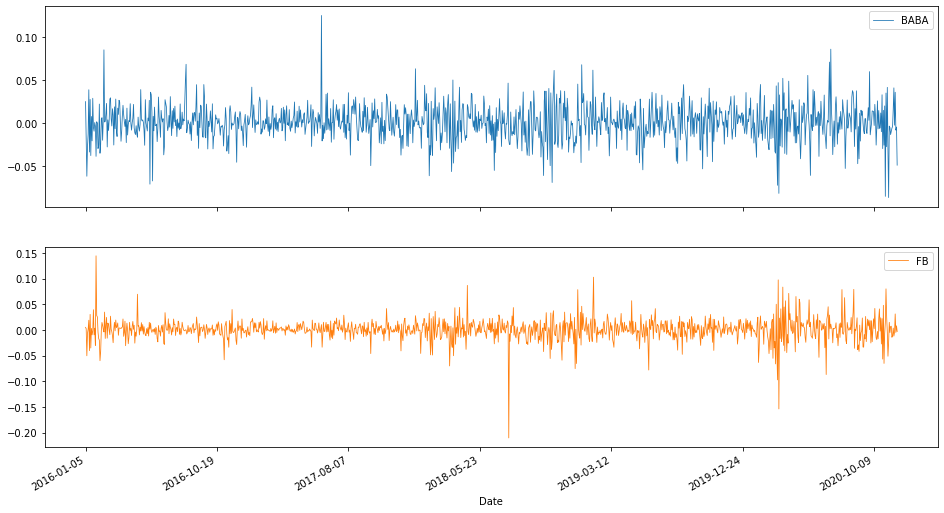

In [8]:
returns.plot(figsize = (16,9),subplots = True, linewidth = 0.8)

In [9]:
returns

BABA        FB
Date                          
2016-01-05  0.024982  0.004977
2016-01-06 -0.016671  0.002333
2016-01-07 -0.061466 -0.050287
2016-01-08 -0.026757 -0.006044
2016-01-11 -0.012507  0.001848
...              ...       ...
2020-11-23 -0.002330 -0.004720
2020-11-24  0.035817  0.031139
2020-11-25 -0.008033 -0.004814
2020-11-27 -0.004475  0.008023
2020-11-30 -0.048617 -0.003028

[1236 rows x 2 columns]

In [10]:
from utility import VAR

importing Jupyter notebook from utility.ipynb


In [11]:
model = VAR(returns, lag = 1)
model.report()

Estimate Coefficient           SD of Estimate            \
                              BABA        FB           BABA        FB   
(Lag_1, BABA)             0.026525 -0.030452       0.032299  0.032653   
(Lag_1, FB)              -0.045617 -0.078142       0.031753  0.032102   
constant                  0.001008  0.000901       0.000588  0.000595   

              t-Statistic            
                     BABA        FB  
(Lag_1, BABA)    0.821254 -0.932594  
(Lag_1, FB)     -1.436612 -2.434177  
constant         1.712616  1.515292

In [12]:
model.p_value < 0.05

BABA     FB
(Lag_1, BABA)  False  False
(Lag_1, FB)    False   True
constant       False  False

In [13]:
model.IC(lag = 10,)

In [14]:
model.stability()

Stability status: [o] STABLE


# Part 2: Cointegration

In [15]:
coint_prices = pd.read_csv('data.csv',index_col = 'Date')
FB = pd.DataFrame(coint_prices['FB'])
BABA = pd.DataFrame(coint_prices['BABA'])

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f9c7f616970>,
      dtype=object)

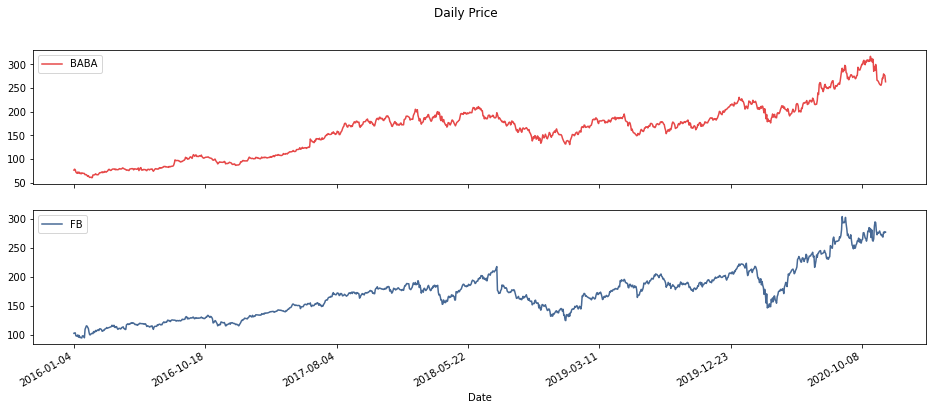

In [16]:
coint_prices.plot( figsize = (16,6),
                  color = ['#E64848','#476995'],
                  subplots = True,
                 title = 'Daily Price',)

# Engle Granger step 1

In [17]:
from utility import LinearRegression as LR

In [18]:
model = LR(x = BABA, y = FB) 
model.report()

Estimate Coefficient SD of Estimate t-Statistic
                           FB             FB          FB
BABA                 0.729003       0.006459  112.858842
constant            52.451564       1.105572   47.442911

In [19]:
#b_coint, constant
model.coef

FB
BABA       0.729003
constant  52.451564

In [20]:
residuals = pd.DataFrame(model.error.reshape(1,1237)[0],
                         index = BABA.index,
                         columns = ['Residual(FB)'])
residuals.head()

Residual(FB)
Date                    
2016-01-04     -6.138810
2016-01-05     -7.043070
2016-01-06     -5.855372
2016-01-07     -7.544670
2016-01-08     -6.734982

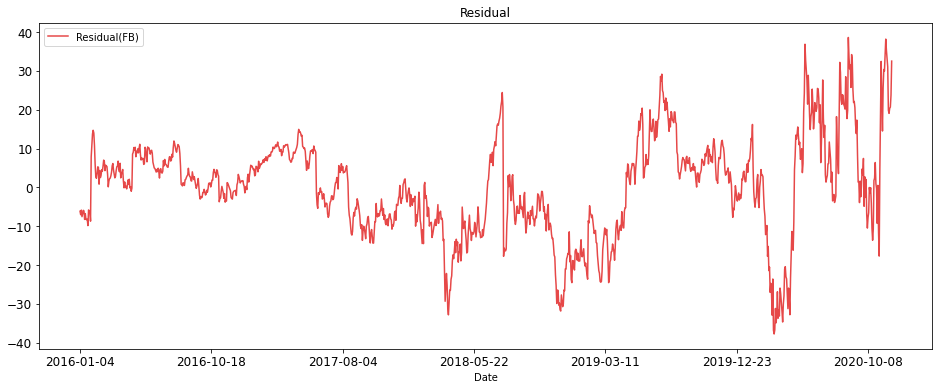

In [21]:
residuals.plot(figsize = (16,6),
              color = '#E64848',
              title = 'Residual',
              fontsize = 12)

In [22]:
from utility import ADF

In [23]:
adf_test = ADF(residuals)
adf_test.report()

The T-value is [-4.6388966] which is lower than -3.45
[*]We reject the  𝐻0  hypothesis of unit root. The residuals are stationary.


# Engle Granger step 2


$$ {  ΔPA_{𝑡}=𝜑ΔPB_{𝑡} − (1−𝛼)𝑒ˆ𝑡−1+𝜀_{𝑡} }$$

$$ { ΔFB𝑡 = 𝜑ΔBABA_{𝑡} −(1−𝛼)CointResidual(FB \; on \; BABA_{𝑡−1}) + 𝜀_{t} }$$

In [24]:
Δy = pd.DataFrame(FB).diff().dropna().add_prefix('Δ')
Δx = pd.DataFrame(BABA).diff().dropna().add_prefix('Δ')

X = Δx.join(residuals.shift(1).dropna().add_prefix('(Lag 1, ').add_suffix(')'))

model = LR(X, Δy,add_const = False)
model.report()
#step_2 = linear_regression(Δy, X, '')
#step_2.fit


Estimate Coefficient SD of Estimate t-Statistic
                                       ΔFB            ΔFB         ΔFB
ΔBABA                             0.492035       0.025909   18.991042
(Lag 1, Residual(FB))            -0.033257       0.007627   -4.360584

In [26]:
model.p_value < 0.05

ΔFB
ΔBABA                  True
(Lag 1, Residual(FB))  True